### This notebook applies k-means clustering on the dataset.

*Aim*: To create different levels of treatments provided in a certain district in two domains - the lower level health centres (SubCentres, Primary Health Care Centres and Community Health Centres) and higher level health centres (Sub Divisional Hospitals and District Hospitals).

We start by importing the necessary packages - `csv` for us to use `csv.writer` to write our merged dataset into a csv file, `mpl_toolkits.mplot3d` for 3d plots and `matplotlib.pyplot` for 2d plots.

In [48]:
import csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Function to detect if a particular string can be converted to an integer or not. The implementation is based on the concept of exception handling, i.e, if there is an exception while trying to convert the string to number, return `false`, else return `true`.

In [49]:
def isInteger(str):
	try:
		num = int(str)
	except ValueError:
		return False
	return True

Function to find the integer value of a certain string.

In [50]:
def intValueOf(str):
	if isInteger(str):
		return int(str)
	else:
		return 0

Initializing lists to contain the number of centres per district, and variables to contain the maximum number of centres to set initial centroids of the cluster.

In [51]:
# list for number of centres per district
subCentres = []
primaryCentres = []
communityCentres = []
subDivisionalHospitals = []
districtHospitals = []

# variables for the maximum number of a particular centre
maxSubCentres = 0
maxPrimaryCentres = 0
maxCommunityCentres = 0
maxSubDivisionalHospitals = 0
maxDistrictHospitals = 0

datasetList = []

Storing the list of rows in the dataset

In [52]:
with open('../data/AddedAttributesMerged.csv', 'r') as dataset:
	datasetList = list(dataset)

The below cell results in several lists consisting of the **normalized figure** of a particular centre in a certain district.

The normalization is done by dividing by `totalPopulation` and multiplying by a factor **proportional to the number of beds** according to the government guidelines, as it becomes a measure of the number of people it can accommodate.
Also, the figures were then multiplied by 10^5 to improve readability in the clustering graph while keeping the spatial arrangement in the graph unchanged.

*Note: Lower and Higher healthcare centres were treated differently and the proportionality factors were calculated independently for both the categories.*

Also, it calculates the maximum figure of a particular centre.

In [53]:
headingRow = True
for row in datasetList:
	#skip first row
	if headingRow:
		headingRow = False
		continue
	
    #get elements of the row
	rowList = row.split(",")

	totalPopulation = intValueOf(rowList[8].strip())
    
    #Normalized figure for each centres
	noOfSubCentres = intValueOf(rowList[17].strip()) * (10 ** 5) / (20 * totalPopulation)
	noOfPrimaryCentres = intValueOf(rowList[18].strip()) * (10 ** 5) / (5 * totalPopulation)
	noOfCommunityCentres = intValueOf(rowList[19].strip()) * (10 ** 5) * 2 / totalPopulation
	noOfSubDivisional = intValueOf(rowList[20].strip()) * (10 ** 5) / (3 * totalPopulation)
	noOfDistrict = intValueOf(rowList[21].strip()) * (10 ** 5) / totalPopulation
    
    #check if the normalized figure of centres is greater than the current max figure of centres
	maxSubCentres = noOfSubCentres if noOfSubCentres > maxSubCentres else maxSubCentres
	maxPrimaryCentres = noOfPrimaryCentres if noOfPrimaryCentres > maxPrimaryCentres else maxPrimaryCentres
	maxCommunityCentres = noOfCommunityCentres if noOfCommunityCentres > maxCommunityCentres else maxCommunityCentres
	maxSubDivisionalHospitals = noOfSubDivisional if noOfSubDivisional > maxSubDivisionalHospitals else maxSubDivisionalHospitals
	maxDistrictHospitals = noOfDistrict if noOfDistrict > maxDistrictHospitals else maxDistrictHospitals

    #adding the figures to the respective list
	subCentres.append(noOfSubCentres)
	primaryCentres.append(noOfPrimaryCentres)
	communityCentres.append(noOfCommunityCentres)
	subDivisionalHospitals.append(noOfSubDivisional)
	districtHospitals.append(noOfDistrict)

Initalizing lists to hold the lower and higher health level of the districts.

In [54]:
lowerHealthLevel = []
higherHealthLevel = []
for i in range(len(datasetList)):
	lowerHealthLevel.append(0)
	higherHealthLevel.append(0)

Finding the level of a certain district and assosciating it with a colour

In [55]:
# colour according to the lower level
def findColourForLower(index):
    # find which centroid it is closest to
	minDistanceCentroid = findMinDistanceCentroidLower(index)
	if minDistanceCentroid == 1:
		return 'red'
	elif minDistanceCentroid == 2:
		return 'green'
	elif minDistanceCentroid == 3:
		return 'orange'
	elif minDistanceCentroid == 4:
		return 'blue'
    
# colour according to the higher level
def findColourForHigher(index):
    # find which centroid it is closest to
	minDistanceCentroid = findMinDistanceCentroidHigher(index)
	if minDistanceCentroid == 1:
		return 'red'
	elif minDistanceCentroid == 2:
		return 'green'
	elif minDistanceCentroid == 3:
		return 'blue'

Finding the centroid a particular point is closest to in the higher and lower level plot respectively.

In [56]:
# which centroid is the point closest to in the lower level plot
def findMinDistanceCentroidLower(index):
	minDistance = findDistanceLower(index, centroidLower1)
	minCentroid = 1
	if findDistanceLower(index, centroidLower2) < minDistance:
		minDistance = findDistanceLower(index, centroidLower2)
		minCentroid = 2
	if findDistanceLower(index, centroidLower3) < minDistance:
		minDistance = findDistanceLower(index, centroidLower3)
		minCentroid = 3
	if findDistanceLower(index, centroidLower4) < minDistance:
		minDistance = findDistanceLower(index, centroidLower4)
		minCentroid = 4
	return minCentroid

# which centroid is the point closest to in the higher level plot
def findMinDistanceCentroidHigher(index):
	minDistance = findDistanceHigher(index, centroidHigher1)
	minCentroid = 1
	if findDistanceHigher(index, centroidHigher2) < minDistance:
		minDistance = findDistanceHigher(index, centroidHigher2)
		minCentroid = 2
	if findDistanceHigher(index, centroidHigher3) < minDistance:
		minDistance = findDistanceHigher(index, centroidHigher3)
		minCentroid = 3
	return minCentroid

Finding the distance between a point and a centroid in higher and lower level plots.

In [57]:
# distance from the centroid in the higher level plot
def findDistanceHigher(index, centroid):
	return ((centroid[0] - subDivisionalHospitals[index]) ** 2 + (centroid[1] - districtHospitals[index]) ** 2) ** 1 / 2

# distance from the centroid in the lower level plot
def findDistanceLower(index, centroid):
	return ((centroid[0] - subCentres[index]) ** 2 + (centroid[1] - primaryCentres[index]) ** 2 + (centroid[2] - communityCentres[index]) ** 2) ** 1 / 2

The cell below applies the k-means clustering algorithm on the lower level health care normalized figures.

*Choosing the initial centroid:* The data was spread in 3 dimensions. 4 cluster centroids were chosen (to indicate 4 levels), spread equidistant from each other along the diagonal connecting the origin and the maximum value of each centre, that is, the initial centroids were *(0, 0, 0), (maxSubCentres / 3, maxPrimaryCentres / 3, maxCommunityCentres / 3), (maxSubCentres * 2 / 3, maxPrimaryCentres * 2 / 3, maxCommunityCentres * 2 / 3), (maxSubCentres, maxPrimaryCentres, maxCommunityCentres)*. In doing so, we would be successfully creating different levels of medical amenities on the basis of our normalized figure.

Each point is assigned to the closest centroid and a new centroid is created. This procedure is repeated 4 times and it is observed that the new centroid converges.

It is rather interesting to observe that no point lies in level 3.


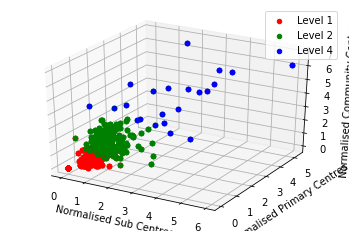

In [58]:
#Initial centroids of lower level plots
centroidLower1 = [0, 0, 0] # red
centroidLower2 = [maxSubCentres / 3, maxPrimaryCentres / 3, maxCommunityCentres / 3] # green
centroidLower3 = [maxSubCentres * 2 / 3 , maxPrimaryCentres * 2 / 3, maxCommunityCentres * 2 / 3] # orange
centroidLower4 = [maxSubCentres, maxPrimaryCentres, maxCommunityCentres] # blue

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for times in range(4):
	sumCentroid1 = [0, 0, 0]
	sumCentroid2 = [0, 0, 0]
	sumCentroid3 = [0, 0, 0]
	sumCentroid4 = [0, 0, 0]

	noOfElementsCentroid1 = 0
	noOfElementsCentroid2 = 0
	noOfElementsCentroid3 = 0
	noOfElementsCentroid4 = 0
	for index in range(len(subCentres)):
		colour = findColourForLower(index);
		if colour == 'red':
			lowerHealthLevel[index] = 1
			noOfElementsCentroid1 += 1
			sumCentroid1 = [sumCentroid1[0] + subCentres[index], sumCentroid1[1] + primaryCentres[index], sumCentroid1[2] + communityCentres[index]]
			if noOfElementsCentroid1 == 1 and times == 3:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour, label = 'Level 1')
			else:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour)
		elif colour == 'green':
			lowerHealthLevel[index] = 2
			noOfElementsCentroid2 += 1
			sumCentroid2 = [sumCentroid2[0] + subCentres[index], sumCentroid2[1] + primaryCentres[index], sumCentroid2[2] + communityCentres[index]]
			if noOfElementsCentroid2 == 1 and times == 3:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour, label = 'Level 2')
			else:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour)
		elif colour == 'orange':
			lowerHealthLevel[index] = 3
			noOfElementsCentroid3 += 1
			sumCentroid3 = [sumCentroid1[0] + subCentres[index], sumCentroid3[1] + primaryCentres[index], sumCentroid3[2] + communityCentres[index]]
			if noOfElementsCentroid3 == 1 and times == 3:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour, label = 'Level 3')
			else:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour)
		elif colour == 'blue':
			lowerHealthLevel[index] = 4
			noOfElementsCentroid4 += 1
			sumCentroid4 = [sumCentroid4[0] + subCentres[index], sumCentroid4[1] + primaryCentres[index], sumCentroid4[2] + communityCentres[index]]
			if noOfElementsCentroid4 == 1 and times == 3:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour, label = 'Level 4')
			else:
				ax.scatter(subCentres[index], primaryCentres[index], communityCentres[index], c = colour)
# find new centroids
	if noOfElementsCentroid1 != 0:
		centroidLower1 = [sumCentroid1[0] / noOfElementsCentroid1, sumCentroid1[1] / noOfElementsCentroid1, sumCentroid1[0] / noOfElementsCentroid1]
	if noOfElementsCentroid2 != 0:
		centroidLower2 = [sumCentroid2[0] / noOfElementsCentroid2, sumCentroid2[1] / noOfElementsCentroid2, sumCentroid2[0] / noOfElementsCentroid2]
	if noOfElementsCentroid3 != 0:
		centroidLower3 = [sumCentroid3[0] / noOfElementsCentroid3, sumCentroid3[1] / noOfElementsCentroid3, sumCentroid3[0] / noOfElementsCentroid3]
	if noOfElementsCentroid4 != 0:
		centroidLower4 = [sumCentroid4[0] / noOfElementsCentroid4, sumCentroid4[1] / noOfElementsCentroid4, sumCentroid4[0] / noOfElementsCentroid4]

ax.legend()

ax.set_xlabel('Normalised Sub Centres')
ax.set_ylabel('Normalised Primary Centres')
ax.set_zlabel('Normalised Community Centres')

plt.show()

The cell below applies the k-means clustering algorithm on the higher level health care normalized figures.

*Choosing the initial centroids:* The data was spread in 2 dimensions sticking closely to the axes, suggesting a negative correlation in the district hospital parameter and the sub divisional parameter. 3 cluster centroids were chosen, one at the *origin*, suggesting the lowest level, one on the sub divisional axis at a distance of *maxSubDivisionalCentres / 2* to mark the second level, and the last level to be in the cluster defined by the initial centroid on the district hospital axis at a distance of *maxDistrictHospital / 4*. The reason to divide by 4 instead of 2 is that the max value can rather be seen as an outlier in this case, and the next maximums are concentrated around the region around the distance of maxDistrictHospital / 4. The reason for the second level to be at the sub divisional axis is that sub divisional hospitals come below district hospitals in the hierarchy of medical facilities.

Each point is assigned to the closest centroid and a new centroid is created. This procedure is repeated 4 times and it is observed that the new centroid converges.

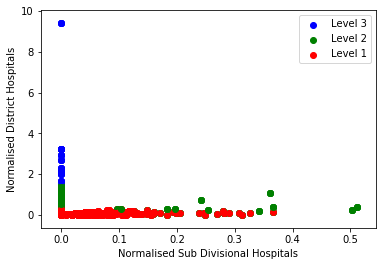

In [59]:
#Initial Centroids for higher health level plot
centroidHigher1 = [0, 0] # red
centroidHigher2 = [maxSubDivisionalHospitals / 2, 0] # green
centroidHigher3 = [0, maxDistrictHospitals / 4] # blue
for times in range(4):
	sumCentroid1 = [0, 0]
	sumCentroid2 = [0, 0]
	sumCentroid3 = [0, 0]

	noOfElementsCentroid1 = 0
	noOfElementsCentroid2 = 0
	noOfElementsCentroid3 = 0
	for index in range(len(subDivisionalHospitals)):
		colour = findColourForHigher(index);
		if colour == 'red':
			higherHealthLevel[index] = 1
			noOfElementsCentroid1 += 1
			sumCentroid1 = [sumCentroid1[0] + subDivisionalHospitals[index], sumCentroid1[1] + districtHospitals[index]]
			if noOfElementsCentroid1 == 1 and times == 3:
				plt.scatter(subDivisionalHospitals[index], districtHospitals[index], c = colour, label = 'Level 1')
			else:
				plt.scatter(subDivisionalHospitals[index], districtHospitals[index], c = colour)

		elif colour == 'green':
			higherHealthLevel[index] = 2
			noOfElementsCentroid2 += 1
			sumCentroid2 = [sumCentroid2[0] + subDivisionalHospitals[index], sumCentroid2[1] + districtHospitals[index]]
			if noOfElementsCentroid2 == 2 and times == 3:
				plt.scatter(subDivisionalHospitals[index], districtHospitals[index], c = colour, label = 'Level 2')
			else:
				plt.scatter(subDivisionalHospitals[index], districtHospitals[index], c = colour)
		elif colour == 'blue':
			higherHealthLevel[index] = 3
			noOfElementsCentroid3 += 1
			sumCentroid3 = [sumCentroid3[0] + subDivisionalHospitals[index], sumCentroid3[1] + districtHospitals[index]]
			if noOfElementsCentroid3 == 1 and times == 3:
				plt.scatter(subDivisionalHospitals[index], districtHospitals[index], c = colour, label = 'Level 3')
			else:
				plt.scatter(subDivisionalHospitals[index], districtHospitals[index], c = colour)
# find new centroids
	if noOfElementsCentroid1 != 0:
		centroidHigher1 = [sumCentroid1[0] / noOfElementsCentroid1, sumCentroid1[1] / noOfElementsCentroid1]
	if noOfElementsCentroid2 != 0:
		centroidHigher2 = [sumCentroid2[0] / noOfElementsCentroid2, sumCentroid2[1] / noOfElementsCentroid2]
	if noOfElementsCentroid3 != 0:
		centroidHigher3 = [sumCentroid3[0] / noOfElementsCentroid3, sumCentroid3[1] / noOfElementsCentroid3]
plt.legend()
plt.xlabel('Normalised Sub Divisional Hospitals')
plt.ylabel('Normalised District Hospitals')
plt.show()

Initializing the final list of values with the headings

In [60]:
finalList = []
finalList.append(['State', 'District', 'SC Current', 'ST Current', 'General Current', 'SC Covered', 'ST Covered', 'General Covered', 'Total Population', 'Percentage SC', 'Percentage SC covered',  'Percentage ST', 'Percentage ST covered',  'Percentage General', 'Percentage General Covered', 'State Index', 'Backward Concentrated', 'Number of Sub Centres', 'Number of Primary Health Centres', 'Number of Community Health Centres', 'Sub Divisional Hospitals', 'District Hospitals', 'Lower Health Centre Level', 'Higher Health Centre Level'])

Adding the lower and higher health level to the list

In [61]:
headingRow = True
for row in range(len(datasetList)):
	if headingRow:
		headingRow = False
		continue
		
	rowList = datasetList[row].split(",")
	rowList[len(rowList) - 1] = rowList[len(rowList) - 1].strip()
	rowList.append(lowerHealthLevel[row - 1])
	rowList.append(higherHealthLevel[row - 1])
	finalList.append(rowList)

Writing the new list into a new *.csv* file `MergedWithHealthLevels.csv`

In [63]:
with open('../data/MergedWithHealthLevels.csv', 'w') as merged:
	writer = csv.writer(merged)
	writer.writerows(finalList)